## Imports

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from scipy.optimize import minimize

tf.compat.v1.disable_eager_execution()

## Hyperparameters

The hyperparameters determine the influence of content and style. If we were to increase `style_weight`, the style image's influence would increased.

In [2]:
content_weight = 0.02
style_weight = 15.0
total_variation_weight = 3.0

## Load and preprocess the content and style images

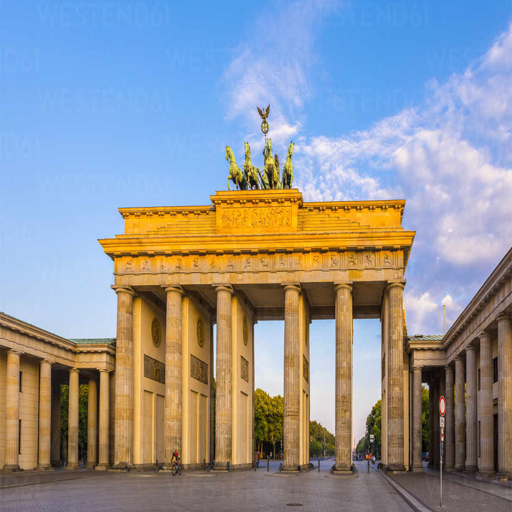

In [3]:
height = 512
width = 512

content_image = Image.open('in/content/brandenburger-tor.jpg')
content_image = content_image.resize((width, height))
content_image

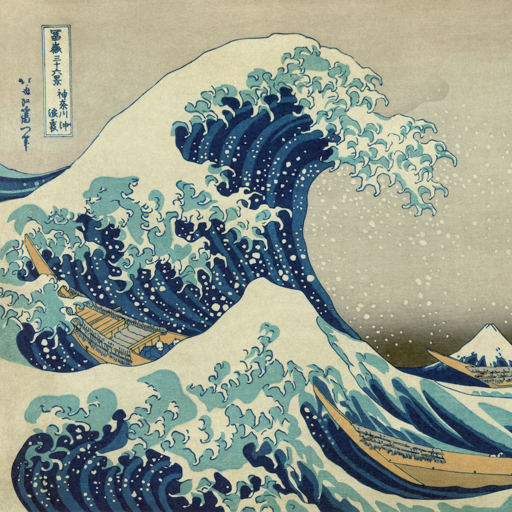

In [4]:
style_image = Image.open('in/style/wave.jpg')
style_image = style_image.resize((width, height))
style_image

We expand the dimensions of the images to later merge all three images into one structure.

In [5]:
content_array = np.asarray(np.asarray(content_image), dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(np.asarray(style_image), dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

style_array.shape

(1, 512, 512, 3)

We then prepare the images for VGG. This is similar to the `VGG.preprocess_input` function.

In [6]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Define input variables:
- the content image is not changed
- the style image is not changed
- the combination image is changed by the optimizer

The combination image will be initialized to a white-noise image.

In [7]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Add all together for classification in VGG network

In [8]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [9]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

## Losses

Create variable for the total loss.

In [10]:
loss = backend.variable(0.)

### Content loss
Johnson et.al. 2016 are using `block2_conv2`, Gatys et al. 2015 use `block4_conv2`. We decided to use Johnsons approach as it provides more structural detail.

In [11]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

# Map layers to their output
layers = dict([(layer.name, layer.output) for layer in model.layers])
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

We are using the Gram matrices, which measure co-occurrence of features, of the combined image and the style image to calculate the style loss.  
We compare 5 different convolutional layers for an accurate value.


In [12]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [13]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

We compare the color values of adjacent pixels and add their difference to the loss. This should smoothen the colouring.

In [14]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Optimizing step


In [15]:
grads = backend.gradients(loss, combination_image)

We calculate both the loss and gradient values in `loss_function` and cache the gradient in `grad_values` for later usage in `grads_function`.  
This improves performance.

In [16]:
outputs = [loss] + grads
# create the computation function that is used to backpropagate to combination_image
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


grad_values = None

def loss_function(x):
    global grad_values
    loss_value, grad_values = eval_loss_and_grads(x)
    return loss_value

def grads_function(x):
    global grad_values
    grad_values_copy = np.copy(grad_values)
    return grad_values_copy


## Generating the Combined Image

The combined image is intialized as a white-noise image.  
We can now optimize the combined Image using *Limited-memory BFGS*. The optimization runs 10 iterations and takes about 60 seconds on google colab.

In [17]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

# number of iterations (~50sec for first iteration, 6sec each after)
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()

    res = minimize(loss_function, x.flatten(), method='L-BFGS-B',
                  jac=grads_function, options={'maxiter': 20})
    x = res.x

    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Iteration 0 completed in 12s
Start of iteration 1
Iteration 1 completed in 5s
Start of iteration 2
Iteration 2 completed in 5s
Start of iteration 3
Iteration 3 completed in 5s
Start of iteration 4
Iteration 4 completed in 5s
Start of iteration 5
Iteration 5 completed in 5s
Start of iteration 6
Iteration 6 completed in 5s
Start of iteration 7
Iteration 7 completed in 5s
Start of iteration 8
Iteration 8 completed in 5s
Start of iteration 9
Iteration 9 completed in 5s


To get a pleasing result, the preprocessing has to be reversed on the resulting image.

In [18]:
# undo the image preprocessing
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

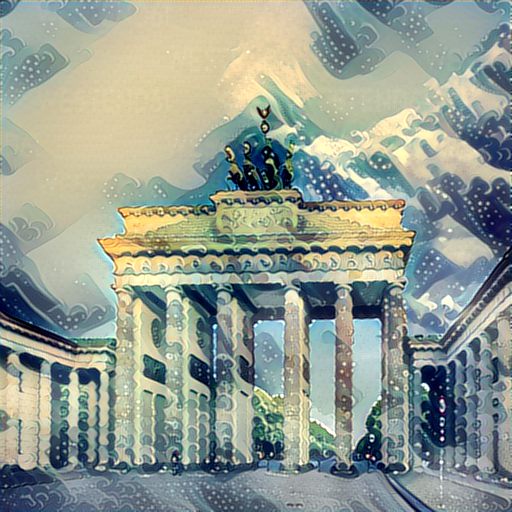

In [19]:
im = Image.fromarray(x)
# im.save('result.png')
im

During this project, we built an Interface, which allows us to easily change the hyperparameters and the used *CNN*.  
If you want to know how to do this whole process in only 10 Lines of code, have a look at *Demo_module.ipynb*.